In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import cv2
import tensorflow as tf
import shutil

In [2]:
pydicom.__version__
tf.__version__# 要用2.0以上的版本Y

'2.12.0'

# 数据预处理

## 数据读取

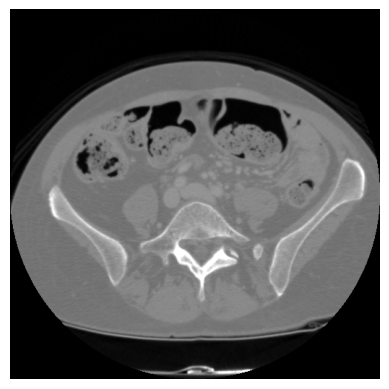

In [3]:
data_path = r'D:\DATA\Academic\acdemic_source\data\3Dircadb\3Dircadb1.1\PATIENT_DICOM'
#读取单张图片
img = pydicom.dcmread(os.path.join(data_path,'image_0'))
plt.imshow(img.pixel_array,cmap='gray')#灰度图
plt.axis('off')#去掉坐标轴
plt.show()

In [4]:
#批量数据读取
image_slices = [pydicom.dcmread(os.path.join(data_path,file_name)) for file_name in os.listdir(data_path)]
os.listdir(data_path)#默认按照字符排序，顺序乱掉了
#重新排序,避免CT图乱序
image_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
#提取像素值
image_array = np.array([i.pixel_array for i in image_slices])

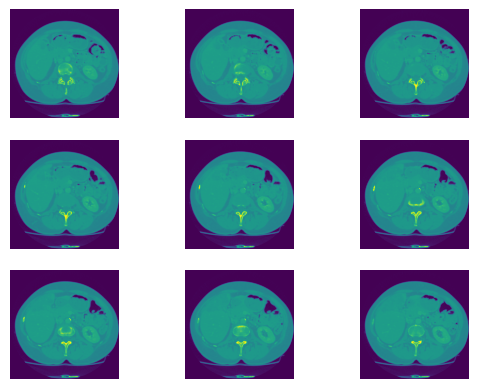

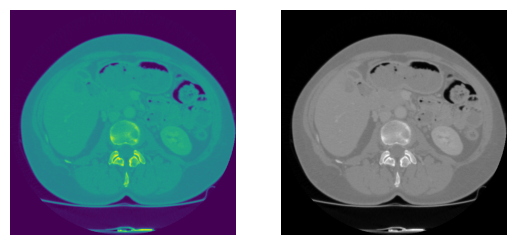

In [5]:
#可视化展示读取的数据
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(image_array[i])
    plt.axis('off')
    j += 1
plt.show()

plt.subplot(1,2,1)
plt.imshow(image_array[51])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image_array[51],cmap='gray')
plt.axis('off')
plt.show()

## CT图增强-windowing

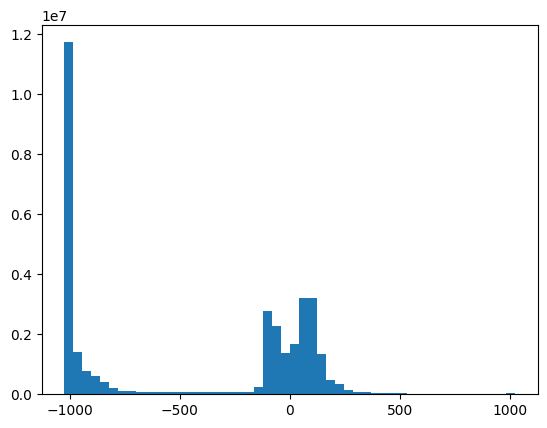

In [6]:
plt.hist(image_array.reshape(-1,),bins=50)
plt.show()

In [7]:
#给定windowing自定义函数
def windowing(img, window_width, window_center):
    #img： 需要增强的图片
    #window_width:窗宽
    #window_center:中心
    minWindow = float(window_center)-0.5*float(window_width)
    new_img = (img-minWindow)/float(window_width)
    new_img[new_img<0] = 0
    new_img[new_img>1] = 1
    return (new_img*255).astype('uint8') #把数据整理成标准图像格式

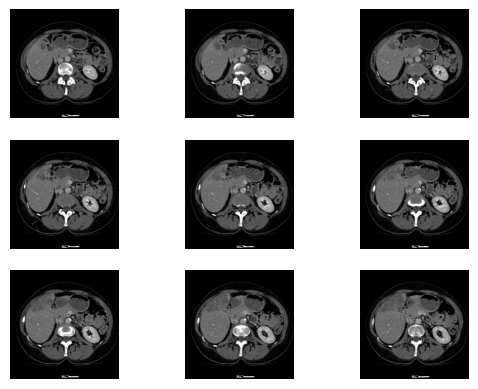

In [8]:
img_ct = windowing(image_array,500,150)
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(img_ct[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

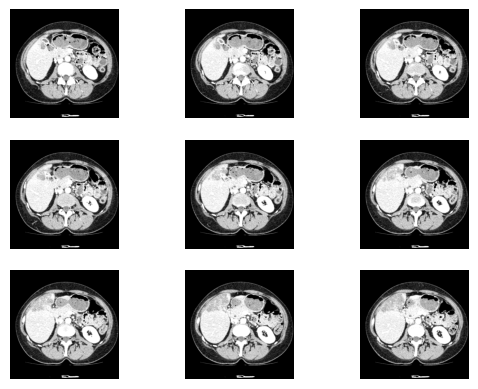

In [9]:
img_ct = windowing(image_array,250,0)
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(img_ct[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

## 直方图均衡化

In [10]:
# img_ct.shape
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize= (8,8))
# clahe.apply(img_ct[0])#一次只能处理一张图片
#自定义批量均衡化函数
def clahe_equalized(imgs):
    #输入imgs的形状必须是3维的 （129,512,512）
    assert(len(imgs.shape ) == 3)
    #定义均衡化函数
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize= (8,8))
    #新数组用来存放均衡化后的数据
    img_res = np.zeros_like(imgs)
    for i in range(len(imgs)):
        img_res[i,:,:] = clahe.apply(np.array(imgs[i,:,:],dtype=np.uint8))
    return img_res/255.0

In [11]:
img_clahe = clahe_equalized(img_ct)

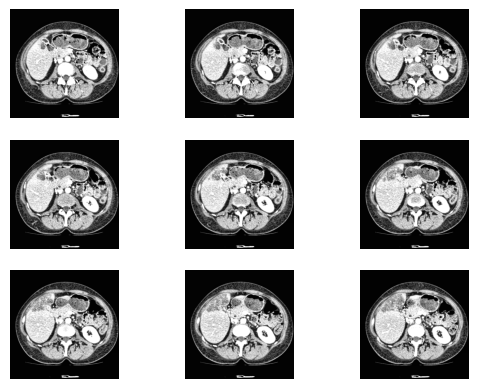

In [12]:
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(img_clahe[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

## 提取肿瘤部位的CT图和掩模图


In [13]:
#只用一个肿瘤示范
data_path_mask = r'D:\DATA\Academic\acdemic_source\data\3Dircadb\3Dircadb1.1\MASKS_DICOM\livertumor01'
#批量数据读取
tumor_slices = [pydicom.dcmread(os.path.join(data_path_mask,file_name)) for file_name in os.listdir(data_path)]
#重新排序,避免CT图乱序
tumor_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
#提取像素值
tumor_array = np.array([i.pixel_array for i in tumor_slices])

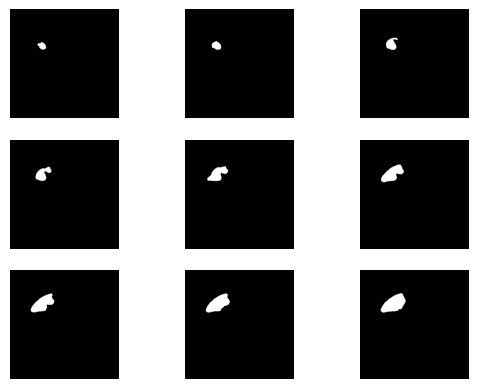

In [14]:
#可视化展示读取的数据
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(tumor_array[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

In [15]:
#没有肿瘤的掩模图全部是黑色,对应的像素数组全为0
index = [i.sum()>0  for i in tumor_array] #提取含肿瘤部分
#提取掩模图的肿瘤部分
img_tumor = tumor_array[index]
#对增强后的CT图提取肿瘤部分
img_patient = img_clahe[index]

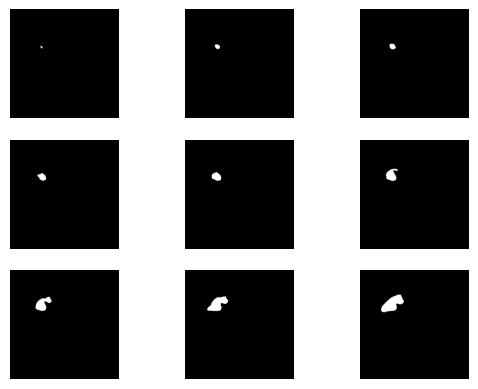

In [16]:
#可视化展示读取的数据
j = 1
for i in range(0,9):
    plt.subplot(3,3,j)
    plt.imshow(img_tumor[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

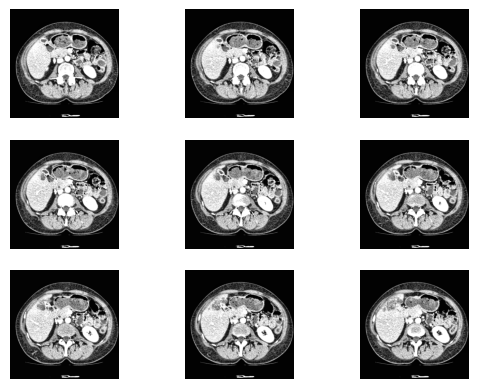

In [17]:
#可视化展示读取的数据
j = 1
for i in range(0,9):
    plt.subplot(3,3,j)
    plt.imshow(img_patient[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

## 保存肿瘤数据

In [18]:
#设置保存文件的路径
patient_save_path = r'D:\DATA\Academic\acdemic_source\data\temp\patient'
tumor_save_path = r'D:\DATA\Academic\acdemic_source\data\temp\tumor'
for path in [patient_save_path,tumor_save_path]:
    if os.path.exists(path): #判断文件夹是否存在
        shutil.rmtree(path)#如果存在就清空
    os.makedirs(path)#新增空文件夹用来存放数据

In [19]:
# #保留一个肿瘤的数据
# for i in range(len(img_patient)):
#     plt.imsave(os.path.join(patient_save_path,f'{i}.jpg'),img_patient[i],cmap = 'gray')#CT图
#     plt.imsave(os.path.join(tumor_save_path,f'{i}.jpg'),img_tumor[i],cmap = 'gray')#掩模图

In [20]:
#保存所有的肿瘤数据
livertumor_path = r'D:\DATA\Academic\acdemic_source\data\3Dircadb\3Dircadb1.1\MASKS_DICOM'
#肿瘤路径
tumor_paths = [os.path.join(livertumor_path,i) for i in os.listdir(livertumor_path) if 'livertumor' in i]
tumor_paths.sort()
#提取所有肿瘤数据
j = 1
for tumor_path in tumor_paths:
    print('正在处理第%d个肿瘤'%j)
    #批量数据读取
    tumor_slices = [pydicom.dcmread(os.path.join(tumor_path,file_name)) for file_name in os.listdir(tumor_path)]
    #重新排序,避免CT图乱序
    tumor_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
    #提取像素值
    tumor_array = np.array([i.pixel_array for i in tumor_slices])
    #没有肿瘤的掩模图全部是黑色,对应的像素数组全为0
    index = [i.sum()>0  for i in tumor_array] #提取含肿瘤部分
    #提取掩模图的肿瘤部分
    img_tumor = tumor_array[index]
    #对增强后的CT图提取肿瘤部分
    img_patient = img_clahe[index]
    #保存数据
    for i in range(len(img_patient)):
        plt.imsave(os.path.join(patient_save_path,f'{j}_{i}.jpg'),img_patient[i],cmap = 'gray')#CT图
        plt.imsave(os.path.join(tumor_save_path,f'{j}_{i}.jpg'),img_tumor[i],cmap = 'gray')#掩模图
    j += 1

正在处理第1个肿瘤
正在处理第2个肿瘤
正在处理第3个肿瘤
正在处理第4个肿瘤
正在处理第5个肿瘤
正在处理第6个肿瘤
正在处理第7个肿瘤


## 对所有病人数据做处理

In [21]:
#设置保存文件的路径
patient_save_path = r'D:\DATA\Academic\acdemic_source\data\temp\patient'
tumor_save_path = r'D:\DATA\Academic\acdemic_source\data\temp\tumor'
for path in [patient_save_path,tumor_save_path]:
    if os.path.exists(path): #判断文件夹是否存在
        shutil.rmtree(path)#如果存在就清空
    os.makedirs(path)#新增空文件夹用来存放数据

In [22]:
sum = 0
for num in range(1,21):
    print('正在处理第%d位病人的数据'%num)
    #======CT图处理===================
    #读取CT图数据
    data_path = fr'D:\DATA\Academic\acdemic_source\data\3Dircadb\3Dircadb1.{num}\PATIENT_DICOM'
    #批量数据读取
    image_slices = [pydicom.dcmread(os.path.join(data_path,file_name)) for file_name in os.listdir(data_path)]
    
    os.listdir(data_path)#默认按照字符排序，顺序乱掉了
    #重新排序,避免CT图乱序
    image_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
    #提取像素值
    image_array = np.array([i.pixel_array for i in image_slices])
    #CT图增强-windowing
    img_ct = windowing(image_array,250,0)
    #直方图均衡化
    img_clahe = clahe_equalized(img_ct)
    #=======掩模图处理==================================
    #保存所有的肿瘤数据
    livertumor_path = fr'D:\DATA\Academic\acdemic_source\data\3Dircadb\3Dircadb1.{num}\MASKS_DICOM'
    #肿瘤路径
    tumor_paths = [os.path.join(livertumor_path,i) for i in os.listdir(livertumor_path) if 'livertumor' in i]
    tumor_paths.sort()
    #提取所有肿瘤数据
    j = 1
    for tumor_path in tumor_paths:
        print('正在处理第%d个肿瘤'%j)
        #批量数据读取
        tumor_slices = [pydicom.dcmread(os.path.join(tumor_path,file_name)) for file_name in os.listdir(tumor_path)]
        #重新排序,避免CT图乱序
        tumor_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
        #提取像素值
        tumor_array = np.array([i.pixel_array for i in tumor_slices])
        #没有肿瘤的掩模图全部是黑色,对应的像素数组全为0
        index = [i.sum()>0  for i in tumor_array] #提取含肿瘤部分
        #提取掩模图的肿瘤部分
        img_tumor = tumor_array[index]
        #对增强后的CT图提取肿瘤部分
        img_patient = img_clahe[index]
        #保存数据
        for i in range(len(img_patient)):
            plt.imsave(os.path.join(patient_save_path,f'{num}_{j}_{i}.jpg'),img_patient[i],cmap = 'gray')#CT图
            plt.imsave(os.path.join(tumor_save_path,f'{num}_{j}_{i}.jpg'),img_tumor[i],cmap = 'gray')#掩模图
        j += 1
        sum += i
print("%d"%sum)

正在处理第1位病人的数据
正在处理第1个肿瘤
正在处理第2个肿瘤
正在处理第3个肿瘤
正在处理第4个肿瘤
正在处理第5个肿瘤
正在处理第6个肿瘤
正在处理第7个肿瘤
正在处理第2位病人的数据
正在处理第1个肿瘤
正在处理第3位病人的数据
正在处理第1个肿瘤
正在处理第4位病人的数据
正在处理第1个肿瘤
正在处理第5位病人的数据
正在处理第6位病人的数据
正在处理第1个肿瘤
正在处理第7位病人的数据
正在处理第8位病人的数据
正在处理第1个肿瘤
正在处理第2个肿瘤
正在处理第3个肿瘤
正在处理第9位病人的数据
正在处理第1个肿瘤
正在处理第10位病人的数据
正在处理第1个肿瘤
正在处理第11位病人的数据
正在处理第12位病人的数据
正在处理第1个肿瘤
正在处理第13位病人的数据
正在处理第1个肿瘤
正在处理第14位病人的数据
正在处理第15位病人的数据
正在处理第1个肿瘤
正在处理第16位病人的数据
正在处理第1个肿瘤
正在处理第17位病人的数据
正在处理第1个肿瘤
正在处理第2个肿瘤
正在处理第18位病人的数据
正在处理第1个肿瘤
正在处理第19位病人的数据
正在处理第1个肿瘤
正在处理第20位病人的数据
619


# 图像数据增强

In [23]:
import os
import shutil
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import  backend as K
from tensorflow.keras.layers import  *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 定义图片生成器

In [24]:
generator_args = dict(
    rotation_range = 0.1,#旋转角度
    width_shift_range = 0.05,#水平移动
    height_shift_range = 0.05,#垂直移动
    shear_range = 0.05,#剪切
    zoom_range = 0.05,#缩放
    horizontal_flip = False,#水平翻转
    vertical_flip = False,#垂直翻转
)
ct_datagen = ImageDataGenerator(generator_args)#CT图片生成器
mask_datagen = ImageDataGenerator(generator_args)#掩模图片生成器

## 图像增强实现

In [25]:
#保存图形增强后数据的路径
save_datagen_path = r'D:\DATA\Academic\acdemic_source\data\temp2'
if os.path.exists(save_datagen_path):
    shutil.rmtree(save_datagen_path)
os.makedirs(save_datagen_path)

In [26]:
#目标路径--ct的增强
generator_path = r'D:\DATA\Academic\acdemic_source\data\temp'
ct_generator = ct_datagen.flow_from_directory(
    generator_path,#目标路径
    classes = ['patient'],#处理的文件夹
    class_mode = None,
    color_mode = 'grayscale',#灰度图
    target_size = (512,512),#图片大小
    batch_size = 2,#图片个数
    save_to_dir = save_datagen_path,#保存
    save_prefix = 'ct_' ,#增强后图片的前缀
    seed = 123,
)
mask_generator = mask_datagen.flow_from_directory(
    generator_path,#目标路径
    classes = ['tumor'],#处理的文件夹
    class_mode = None,
    color_mode = 'grayscale',#灰度图
    target_size = (512,512),#图片大小
    batch_size = 2,#图片个数
    save_to_dir = save_datagen_path,#保存
    save_prefix = 'mask_' ,#增强后图片的前缀
    seed = 123,
)
train_generator = zip(ct_generator,mask_generator)#成组处理

Found 643 images belonging to 1 classes.
Found 643 images belonging to 1 classes.


(512, 512) (2, 512, 512, 1)


d:\SOFTWARE\Anaconda\envs\Torch\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


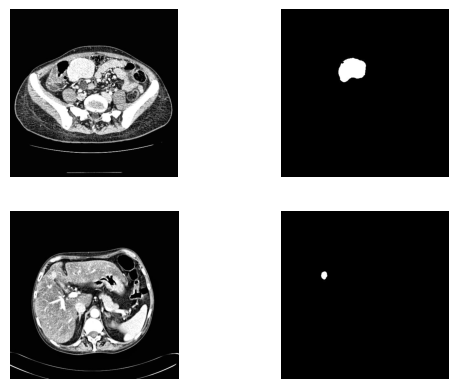

In [27]:
#可视化
for ct,mask in train_generator:
    print(ct[0][:,:,0].shape,mask.shape)
    plt.subplot(2,2,1)
    plt.imshow(ct[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(mask[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(ct[1][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(mask[1][:,:,0],cmap='gray')
    plt.axis('off')
    
    break
plt.show()

## 图像归一化

In [28]:
def adjust_data(ct,mask):
    #ct： CT图
    #mask：掩模图
    ct = ct/255.0
    mask = mask/255.0
    mask[mask>0.5] = 1#对掩模图做灰度处理
    mask[mask<=0.5] = 0
    return ct,mask



## 整合图像增强的步骤

In [34]:
#自定义图像增强函数
def train_generator():
    #======1、定义图像生成器============================
    generator_args = dict(
        rotation_range = 0.1,#旋转角度
        width_shift_range = 0.05,#水平移动
        height_shift_range = 0.05,#垂直移动
        shear_range = 0.05,#剪切
        zoom_range = 0.05,#缩放
        horizontal_flip = False,#水平翻转
        vertical_flip = False,#垂直翻转
    )
    #=====2、分别对CT图和掩模图做图像增强===================================
    ct_datagen = ImageDataGenerator(generator_args)#CT图片生成器
    mask_datagen = ImageDataGenerator(generator_args)#掩模图片生成器
    
    #====3、实现图像增强=====================================================
    generator_path = r'D:\DATA\Academic\acdemic_source\data\temp'
    ct_generator = ct_datagen.flow_from_directory(
        generator_path,#目标路径
        classes = ['patient'],#处理的文件夹
        class_mode = None,
        color_mode = 'grayscale',#灰度图
        target_size = (512,512),#图片大小
        batch_size = 2,#图片个数
        save_to_dir = save_datagen_path,#保存
        save_prefix = 'ct_' ,#增强后图片的前缀
        seed = 123,
    )
    mask_generator = mask_datagen.flow_from_directory(
        generator_path,#目标路径
        classes = ['tumor'],#处理的文件夹
        class_mode = None,
        color_mode = 'grayscale',#灰度图
        target_size = (512,512),#图片大小
        batch_size = 2,#图片个数
        save_to_dir = save_datagen_path,#保存
        save_prefix = 'mask_' ,#增强后图片的前缀
        seed = 123,
    )
    train_generator = zip(ct_generator,mask_generator)#成组处理

    for (ct,mask) in train_generator:
        zecict,zecimask = adjust_data(ct,mask)
        plt.subplot(1,2,1)
        plt.imshow(ct[0][:,:,0], cmap='gray')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(zecict[0][:,:,0], cmap='gray')
        plt.axis('off')
        break
    
    plt.show()
    #============4、增强后的图片做归一化处理==========================
    for (ct,mask) in train_generator:
        yield adjust_data(ct,mask)

Found 643 images belonging to 1 classes.
Found 643 images belonging to 1 classes.


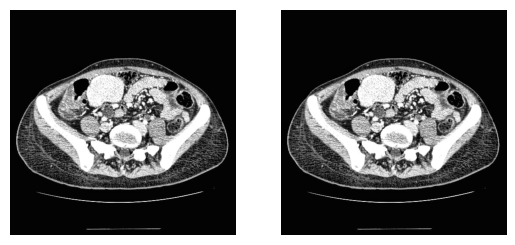

(512, 512) (2, 512, 512, 1)


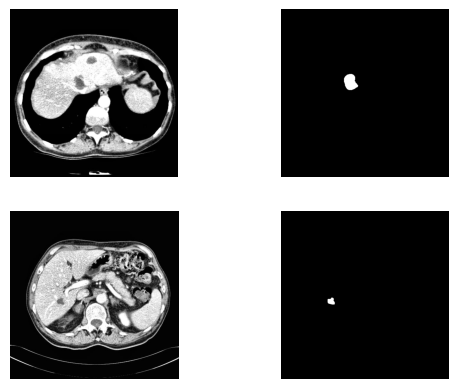

In [35]:
gene = train_generator() #模型的输入和输出，可以直接放在模型的训练里面
#可视化
for ct,mask in gene:
    print(ct[0][:,:,0].shape,mask.shape)
    plt.subplot(2,2,1)
    plt.imshow(ct[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(mask[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(ct[1][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(mask[1][:,:,0],cmap='gray')
    plt.axis('off')
    
    break
plt.show()